In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
import pickle
from scipy import stats
from helper import *

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import *
from sklearn.feature_selection import SelectFromModel, SelectPercentile, mutual_info_classif, chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from genetic_selection import GeneticSelectionCV

In [2]:
datapath = 'data/original/pre-imputed/'

C1W1nonet_df = pd.read_csv(datapath + 'C1W1_nonnetwork_preimputed.csv')
C1pred_df = pd.read_csv(datapath + 'C1_nonnetwork_pred.csv')
C1W1nonet_vars = list(C1W1nonet_df.columns)

C2W1nonet_df = pd.read_csv(datapath + 'C2W1_nonnetwork_preimputed.csv')
C2pred_df = pd.read_csv(datapath + 'C2_nonnetwork_pred.csv')
C2W1nonet_vars = list(C2W1nonet_df.columns)

C1W1nonet_vars == C2W1nonet_vars

True

In [3]:
@ignore_warnings(category=ConvergenceWarning)
def log_regression_tuned(X, y):

    clf = LogisticRegression()
    loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)

def pruned_decision_trees_tuned(X, y):

    clf = DecisionTreeClassifier()
    loocv_scores = cross_val_score(clf, X, y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)

def svm_tuned(X, y):

    clf = SVC()
    loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)


def plot_LC_tuned(X, y, cohort, drug, fgroup, savefile=None, baseline=1, n_estimators=3):

    fig, axes = plt.subplots(1, n_estimators, figsize=(15, 5))

    # Cross validation with 50 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

    title = "Learning Curves (logistic regression)"
    estimator, lg_score = log_regression_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[0], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=lg_score, baseline=baseline
    )

    title = "Learning Curves (decision tree)"
    estimator, dt_score = pruned_decision_trees_tuned(X, y)
    plot_learning_curve(
        estimator, title, X, y, axes=axes[1], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=dt_score, baseline=baseline
    )

    title = "Learning Curves (SVM)"
    estimator, svm_score = svm_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[2], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=svm_score, baseline=baseline
    )

    suptitle = f'Cohort {cohort}: {drug} use, features {fgroup}'
    if len(suptitle) > 120:     suptitle = '-\n'.join(suptitle[j:j+120] for j in range(0,len(suptitle), 120))  # break line if title too long
    fig.suptitle(suptitle)
    fig.tight_layout()
    if savefile is None:
        plt.savefig(f'plots/analysis/learning_curve/C{cohort}-{drug}/C{cohort}-{drug}-{fgroup}_learningCurve.pdf', facecolor='white')
    else:
        plt.savefig(savefile, facecolor='white')

    return lg_score, dt_score, svm_score

In [4]:
fsubs_1, fsubs_2, fsubs_3, fsubs_4 = ['SC'], ['DM'], ['TB','AL','ID','ND','DA','OD'], ['TX','AC','CJ']
fsubs_5 = fsubs_1 + fsubs_2
fsubs_6 = fsubs_1 + fsubs_2 + fsubs_3
fsubs_7 = fsubs_1 + fsubs_2 + fsubs_4
fsubs_8 = fsubs_1 + fsubs_2 + fsubs_3 + fsubs_4
fsubs_nonnet = {'g1': fsubs_1, 'g2': fsubs_2, 'g3': fsubs_3, 'g4': fsubs_4, 'g5': fsubs_5, 'g6': fsubs_6, 'g7': fsubs_7, 'g8': fsubs_8}

fsubs_net = {'g9': ['NSX'], 'g10': ['NDX'], 'g11': ['NSX','NDX']}

fsubs_netnonnet = { 'g12': fsubs_nonnet['g3']+fsubs_net['g10'],
                    'g13': fsubs_nonnet['g6']+fsubs_net['g10'],
                    'g14': fsubs_nonnet['g8']+fsubs_net['g11']}

A list of feature selection methods

In [5]:
word_lim = 90

@ignore_warnings(category=ConvergenceWarning)
def genetic_alg(clf_dict, X_df, X_raw, y, cohort, drug, baseline, savepath, cv=ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)):

    results_dict = {}
    for clf_name, clf in clf_dict.items():
        X = standard_scale(X_raw) if clf_name != 'decision tree' else X_raw
        model = GeneticSelectionCV(
            clf, cv=cv, verbose=0,
            scoring="accuracy", max_features=None,
            n_population=300, crossover_proba=0.5,
            mutation_proba=0.2, n_generations=40,
            crossover_independent_proba=0.1,
            mutation_independent_proba=0.05,
            tournament_size=3, n_gen_no_change=10,
            caching=False)
        model = model.fit(X, y)

        X_new = X[:, model.support_]
        selected_features = list(X_df.columns[model.support_])

        title = f'Learning Curves ({clf_name}) using features selected from genetic algorithm: {selected_features}'
        if len(title) > word_lim:     title = '-\n'.join(title[j:j+word_lim] for j in range(0,len(title), word_lim))  # break line if title too long
        scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
        results_dict[clf_name] = {'cv_score': np.mean(scores), 'features': selected_features}
        plot_learning_curve_v2(
            clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, scoring="accuracy", score=np.mean(scores), baseline=baseline
        )
        plt.savefig(f'{savepath}/GA/C{cohort}-{drug}-{clf_name}_learningCurve.pdf', facecolor='white')

    return results_dict


@ignore_warnings(category=ConvergenceWarning)
def pca(clf_dict, X_df, X_raw, y, cohort, drug, baseline, savepath, cv=ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)):

    results_dict = {}
    for clf_name, clf in clf_dict.items():
        pipe = Pipeline(steps=[("scaler", StandardScaler()), ("pca", PCA()), (clf_name, clf)])
        PC_max = np.min([X_raw.shape[0]-1, X_raw.shape[1]])
        param_grid = {"pca__n_components": np.linspace(2, 20, 7, dtype=np.int32)}
        search = GridSearchCV(pipe, param_grid, cv=cv)
        search.fit(X_raw, y)
        results_dict[clf_name] = {'cv_score': search.best_score_}
        title = f"Learning Curves ({clf_name} from {search.best_params_['pca__n_components']} PCs)"
        plot_learning_curve_v2(
            search.best_estimator_, title, X_raw, y, ylim=(0.1, 1.01), cv=cv, scoring="accuracy", score=search.best_score_, baseline=baseline
        )
        plt.savefig(f'{savepath}/PCA/C{cohort}-{drug}-{clf_name}_learningCurve.pdf', facecolor='white')

    return results_dict


@ignore_warnings(category=ConvergenceWarning)
def chi2_filter(clf_dict, X_df, X_raw, y, cohort, drug, baseline, savepath, cv=ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)):

    results_dict = {}
    for clf_name, clf in clf_dict.items():
        pipe = Pipeline(steps=[("anova", SelectPercentile(chi2)), (clf_name, clf)]) if clf_name == 'decision tree' \
            else Pipeline(steps=[("anova", SelectPercentile(chi2)), ("scaler", StandardScaler()), (clf_name, clf)])
        param_grid = {"anova__percentile": [3, 6, 10, 15, 20, 30, 40]}
        cv = ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
        search = GridSearchCV(pipe, param_grid, cv=cv)
        search.fit(X_raw, y)
        
        X = standard_scale(X_raw) if clf_name != 'decision tree' else X_raw
        X_new = X[:,search.best_estimator_['anova'].get_support()]
        selected_features = list(X_df.columns[search.best_estimator_['anova'].get_support()]) # note that the ordering is lexicographical, not magnitude-based
        results_dict[clf_name] = {'cv_score': search.best_score_, 'features': selected_features}
        title = f"Learning Curves ({clf_name}) using features in the {search.best_params_['anova__percentile']}th (chi2) percentile {selected_features}"
        if len(title) > word_lim:     title = '-\n'.join(title[j:j+word_lim] for j in range(0,len(title), word_lim))  # break line if title too long
        plot_learning_curve_v2(
            clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, scoring="accuracy", score=search.best_score_, baseline=baseline
        )
        plt.savefig(f'{savepath}/chi2/C{cohort}-{drug}-{clf_name}_learningCurve.pdf', facecolor='white')

    return results_dict


class Importances:  # return feature importances (from random forest) for SVM with non-linear kernel
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, clf):
        return permutation_importance(clf, self.X, self.y, n_repeats=10)['importances_mean']


@ignore_warnings(category=ConvergenceWarning)
def thresholding(clf_dict, X_df, X_raw, y, cohort, drug, baseline, savepath, cv=ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)):

    results_dict = {}
    thresholds = [f"{scale}*mean" for scale in [0.1, 0.5, 0.75, 1, 1.25, 1.5, 2]]
    for clf_name, clf in clf_dict.items():
        X = standard_scale(X_raw) if clf_name != 'decision tree' else X_raw
        if clf_name == 'SVM':       clf.kernel = 'linear'  # only linear kernel allows SVM to have coef_
        importances = Importances(X, y) if clf_name == 'SVM' and clf.kernel != 'linear' else 'auto'
        cv_scores = {}
        for i, th in enumerate(thresholds):
            model = SelectFromModel(clf.fit(X, y), prefit=True, importance_getter=importances, threshold=th)
            X_new = model.transform(X)
            features = list(X_df.columns[model.get_support()])
            cv_scores[i] = {'score': np.mean(cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)), 'features': features, 'X_new': X_new}

        best_threshold_idx = np.argmax([i['score'] for i in cv_scores.values()])
        selected_features = cv_scores[best_threshold_idx]['features']
        X_new = cv_scores[best_threshold_idx]['X_new']
        title = f'Learning Curves ({clf_name}) using features above {thresholds[best_threshold_idx]} threshold: {selected_features}'
        if len(title) > word_lim:     title = '-\n'.join(title[j:j+word_lim] for j in range(0,len(title), word_lim))  # break line if title too long
        results_dict[clf_name] = {'cv_score': cv_scores[best_threshold_idx]['score'], 'features': selected_features}
        plot_learning_curve_v2(
            clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, scoring="accuracy", score=cv_scores[best_threshold_idx]['score'], baseline=baseline
        )
        plt.savefig(f'{savepath}/thresholding/C{cohort}-{drug}-{clf_name}_learningCurve.pdf', facecolor='white')

    return results_dict

### Non-network features

In [6]:
%%capture
clf_dict = {'logistic regression': LogisticRegression(),
            'decision tree': DecisionTreeClassifier(),
            'SVM': SVC()}
scores_dict = {}
for cohort in [1, 2, '1+2']:
    for drug in ['marijuana', 'meth']:

        scores_dict[f'{cohort}-{drug}-fgroup'] = []
        scores_dict[f'{cohort}-{drug}-LG'], scores_dict[f'{cohort}-{drug}-DT'], scores_dict[f'{cohort}-{drug}-SVM'] = [], [], []

        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        elif cohort == '1+2':
            nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
            nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])

        df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        indep_vars = list(df.drop(columns=discarded_vars).columns)
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = X_df.drop(nominal_vars, axis=1)
        X_nominal_df = X_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Group features
        f_dict = {}
        fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
        for g in fgroups:
            features = [c for c in Xenc_df if c.startswith(g)]
            f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
            f_dict[g] = f_indices

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        # Domain-specific feature grouping
        for gname, fsubs in fsubs_nonnet.items():
            X = X_imp[:, [f for fgroup in [f_dict[s] for s in fsubs] for f in fgroup]]
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, gname, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(gname)
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        # various feature selection methods
        for m_name, fselect_method in {'pca': pca, 'chi2': chi2_filter, 'thresholding': thresholding, 'genetic alg': genetic_alg}.items():
            results = fselect_method(clf_dict, Xenc_df, X_imp, y, cohort, drug, baseline, 'plots/analysis/learning_curve/feature_selection')
            
            if m_name != 'pca':
                scores_dict[f'{cohort}-{drug}-fgroup'].extend([m_name, np.nan])
                scores_dict[f'{cohort}-{drug}-LG'].extend([results['logistic regression']['cv_score'], results['logistic regression']['features']])
                scores_dict[f'{cohort}-{drug}-DT'].extend([results['decision tree']['cv_score'], results['decision tree']['features']])
                scores_dict[f'{cohort}-{drug}-SVM'].extend([results['SVM']['cv_score'], results['SVM']['features']])
            else:
                scores_dict[f'{cohort}-{drug}-fgroup'].append(m_name)
                scores_dict[f'{cohort}-{drug}-LG'].append(results['logistic regression']['cv_score'])
                scores_dict[f'{cohort}-{drug}-DT'].append(results['decision tree']['cv_score'])
                scores_dict[f'{cohort}-{drug}-SVM'].append(results['SVM']['cv_score'])

        scores_dict[f'{cohort}-{drug}-baseline'] = [baseline] * len(scores_dict[f'{cohort}-{drug}-fgroup'])

pd.DataFrame.from_dict(scores_dict).to_csv('results/scores_nonnetwork.csv', index=False)

### Network features

In [70]:
%%capture
clf_dict = {'logistic regression': LogisticRegression(),
            'decision tree': DecisionTreeClassifier(),
            'SVM': SVC()}
scores_dict = {}
for cohort in [1, 2, '1+2']:
    for drug in ['marijuana', 'meth']:

        scores_dict[f'{cohort}-{drug}-fgroup'] = []
        scores_dict[f'{cohort}-{drug}-LG'], scores_dict[f'{cohort}-{drug}-DT'], scores_dict[f'{cohort}-{drug}-SVM'] = [], [], []

        # csv generated from data_net_analysis.ipynb (Cramer's V section)
        df = pd.read_csv(f"saved-vars/C{''.join(str(cohort).split('+'))}_network-processed.csv")
        if cohort == 1:
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        elif cohort == '1+2':
            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop('pred', axis=1)

        # Group features
        f_dict = {}
        fgroups = ['NSX','NDX']  # feature groups
        for g in fgroups:
            features = [c for c in X_df if c.startswith(g) or g[:2] in c]
            f_indices = [X_df.columns.get_loc(c) for c in X_df if c.startswith(g)]  # column indices of the group's features
            f_dict[g] = f_indices

        X_np = X_df.to_numpy()

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        # Domain-specific feature grouping
        for gname, fsubs in fsubs_net.items():
            X = X_np[:, [f for fgroup in [f_dict[s] for s in fsubs] for f in fgroup]]
            savefile = f'plots/analysis/learning_curve/net/C{cohort}-{drug}/C{cohort}-{drug}-{gname}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, gname, savefile=savefile, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(gname)
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        # various feature selection methods
        for m_name, fselect_method in {'pca': pca, 'chi2': chi2_filter, 'thresholding': thresholding, 'genetic alg': genetic_alg}.items():
            results = fselect_method(clf_dict, X_df, X_np, y, cohort, drug, baseline, 'plots/analysis/learning_curve/net/feature_selection')
            
            if m_name != 'pca':
                scores_dict[f'{cohort}-{drug}-fgroup'].extend([m_name, np.nan])
                scores_dict[f'{cohort}-{drug}-LG'].extend([results['logistic regression']['cv_score'], results['logistic regression']['features']])
                scores_dict[f'{cohort}-{drug}-DT'].extend([results['decision tree']['cv_score'], results['decision tree']['features']])
                scores_dict[f'{cohort}-{drug}-SVM'].extend([results['SVM']['cv_score'], results['SVM']['features']])
            else:
                scores_dict[f'{cohort}-{drug}-fgroup'].append(m_name)
                scores_dict[f'{cohort}-{drug}-LG'].append(results['logistic regression']['cv_score'])
                scores_dict[f'{cohort}-{drug}-DT'].append(results['decision tree']['cv_score'])
                scores_dict[f'{cohort}-{drug}-SVM'].append(results['SVM']['cv_score'])

        scores_dict[f'{cohort}-{drug}-baseline'] = [baseline] * len(scores_dict[f'{cohort}-{drug}-fgroup'])

pd.DataFrame.from_dict(scores_dict).to_csv('results/scores_network.csv', index=False)

### Non-network + network features

KeyboardInterrupt: 

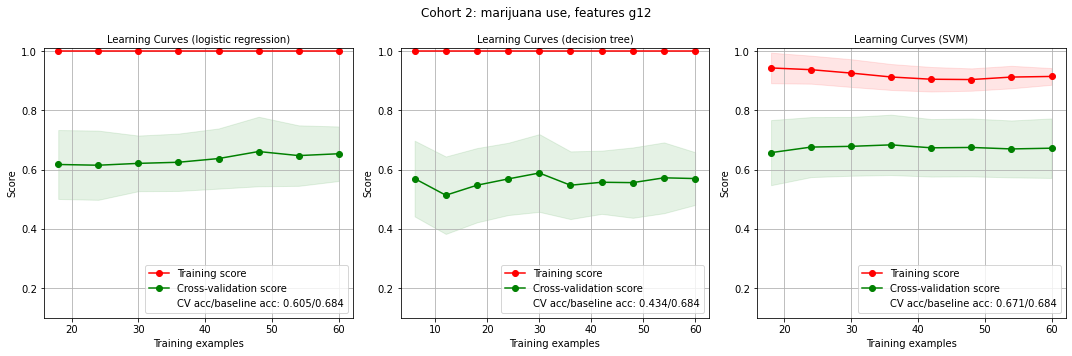

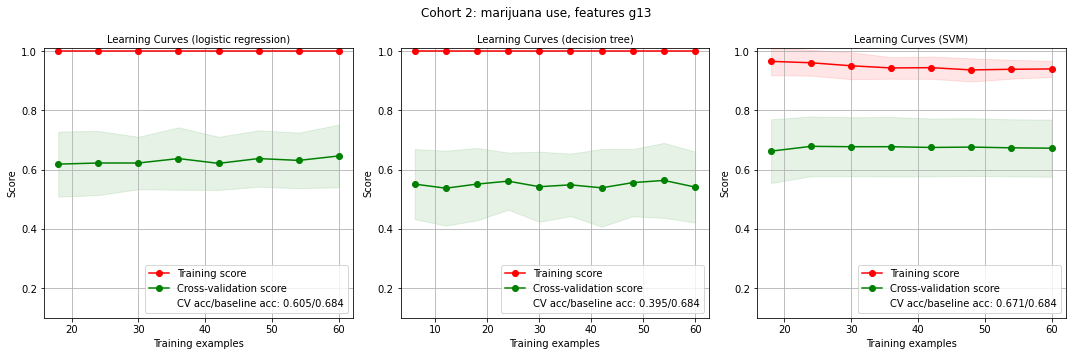

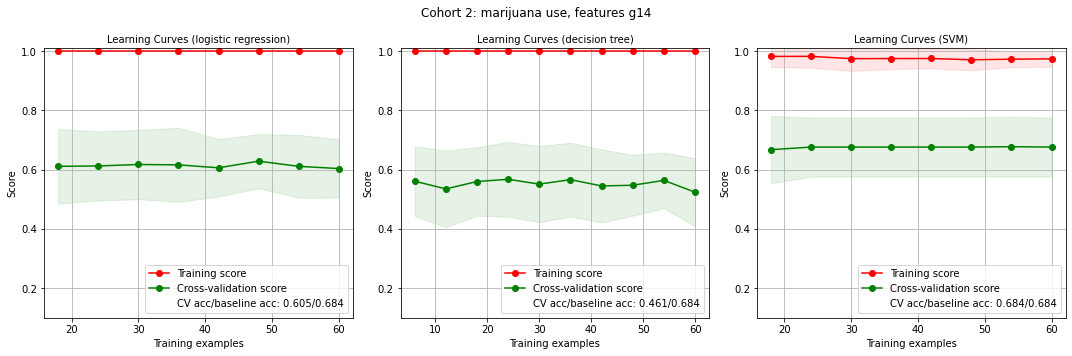

In [7]:
%%capture
clf_dict = {'logistic regression': LogisticRegression(),
            'decision tree': DecisionTreeClassifier(),
            'SVM': SVC()}
scores_dict = {}
for cohort in [2, '1+2']:
    for drug in ['marijuana', 'meth']:

        scores_dict[f'{cohort}-{drug}-fgroup'] = []
        scores_dict[f'{cohort}-{drug}-LG'], scores_dict[f'{cohort}-{drug}-DT'], scores_dict[f'{cohort}-{drug}-SVM'] = [], [], []

        net_df = pd.read_csv(f"saved-vars/C{''.join(str(cohort).split('+'))}_network-processed.csv")
        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        elif cohort == '1+2':
            nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
            nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])

        nonet_df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(nonet_df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        #---------------------------------- Non-network ------------------------------------------------------
        nonet_df = pd.concat([nonet_df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        Xnonet_df = nonet_df[nonet_df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = Xnonet_df.drop(nominal_vars, axis=1)
        X_nominal_df = Xnonet_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Group non-network features
        f_nonet_dict = {}
        fgroups_nonet = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
        for g in fgroups_nonet:
            features = [c for c in Xenc_df if c.startswith(g)]
            f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
            f_nonet_dict[g] = f_indices

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        #---------------------------------- Network ------------------------------------------------------
        net_df = pd.concat([net_df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        Xnet_df = net_df[net_df['pred'].notna()].drop('pred', axis=1)

        # Group network features
        f_net_dict = {}
        fgroups_net = ['NSX','NDX']  # feature groups
        for g in fgroups_net:
            features = [c for c in Xnet_df if c.startswith(g) or g[:2] in c]
            f_indices = [Xnet_df.columns.get_loc(c) for c in Xnet_df if c.startswith(g)]  # column indices of the group's features
            f_net_dict[g] = f_indices

        X_np = Xnet_df.to_numpy()

        #-------------------------------------------------------------------------------------------
        X_all = np.concatenate((X_imp, X_np), axis=1)
        X_df = pd.concat([Xenc_df, Xnet_df], axis=1)

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        # Domain-specific feature grouping
        for gname, fsubs in fsubs_netnonnet.items():
            X_nonet = X_imp[:, [f for fgroup in [f_nonet_dict[s] for s in fsubs if s in fgroups_nonet] for f in fgroup]]
            X_net = X_np[:, [f for fgroup in [f_net_dict[s] for s in fsubs if s in fgroups_net] for f in fgroup]]
            X = np.concatenate((X_nonet, X_net), axis=1)
            savefile = f'plots/analysis/learning_curve/nonnet+net/C{cohort}-{drug}/C{cohort}-{drug}-{gname}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, gname, savefile=savefile, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(gname)
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        # various feature selection methods
        for m_name, fselect_method in {'pca': pca, 'chi2': chi2_filter, 'thresholding': thresholding, 'genetic alg': genetic_alg}.items():
            results = fselect_method(clf_dict, X_df, X_all, y, cohort, drug, baseline, 'plots/analysis/learning_curve/nonnet+net/feature_selection')
            
            if m_name != 'pca':
                scores_dict[f'{cohort}-{drug}-fgroup'].extend([m_name, np.nan])
                scores_dict[f'{cohort}-{drug}-LG'].extend([results['logistic regression']['cv_score'], results['logistic regression']['features']])
                scores_dict[f'{cohort}-{drug}-DT'].extend([results['decision tree']['cv_score'], results['decision tree']['features']])
                scores_dict[f'{cohort}-{drug}-SVM'].extend([results['SVM']['cv_score'], results['SVM']['features']])
            else:
                scores_dict[f'{cohort}-{drug}-fgroup'].append(m_name)
                scores_dict[f'{cohort}-{drug}-LG'].append(results['logistic regression']['cv_score'])
                scores_dict[f'{cohort}-{drug}-DT'].append(results['decision tree']['cv_score'])
                scores_dict[f'{cohort}-{drug}-SVM'].append(results['SVM']['cv_score'])

        scores_dict[f'{cohort}-{drug}-baseline'] = [baseline] * len(scores_dict[f'{cohort}-{drug}-fgroup'])

pd.DataFrame.from_dict(scores_dict).to_csv('results/scores_nonnetwork+network.csv', index=False)

## Sandbox

In [10]:
clf_dict = {'logistic regression': LogisticRegression(),
            'decision tree': DecisionTreeClassifier(),
            'SVM': SVC()}
scores_dict = {}
for cohort in [2]:
    for drug in ['marijuana']:

        scores_dict[f'{cohort}-{drug}-fgroup'] = []
        scores_dict[f'{cohort}-{drug}-LG'], scores_dict[f'{cohort}-{drug}-DT'], scores_dict[f'{cohort}-{drug}-SVM'] = [], [], []

        net_df = pd.read_csv(f"saved-vars/C{''.join(str(cohort).split('+'))}_network-processed.csv")
        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        elif cohort == '1+2':
            nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
            nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])

        nonet_df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(nonet_df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        #---------------------------------- Non-network ------------------------------------------------------
        nonet_df = pd.concat([nonet_df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        Xnonet_df = nonet_df[nonet_df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = Xnonet_df.drop(nominal_vars, axis=1)
        X_nominal_df = Xnonet_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Group non-network features
        f_nonet_dict = {}
        fgroups_nonet = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
        for g in fgroups_nonet:
            features = [c for c in Xenc_df if c.startswith(g)]
            f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
            f_nonet_dict[g] = f_indices

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        #---------------------------------- Network ------------------------------------------------------
        net_df = pd.concat([net_df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        Xnet_df = net_df[net_df['pred'].notna()].drop('pred', axis=1)

        # Group network features
        f_net_dict = {}
        fgroups_net = ['NSX','NDX']  # feature groups
        for g in fgroups_net:
            features = [c for c in Xnet_df if c.startswith(g) or g[:2] in c]
            f_indices = [Xnet_df.columns.get_loc(c) for c in Xnet_df if c.startswith(g)]  # column indices of the group's features
            f_net_dict[g] = f_indices

        X_np = Xnet_df.to_numpy()

        #-------------------------------------------------------------------------------------------
        X_all = np.concatenate((X_imp, X_np), axis=1)
        X_df = pd.concat([Xenc_df, Xnet_df], axis=1)

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

In [11]:
X_all.shape

(76, 250)

In [12]:
X_raw = X_all
# y = y[:75]
cv=ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)

clf_name, clf = 'logistic regression', LogisticRegression()
X = standard_scale(X_raw) if clf_name != 'decision tree' else X_raw
model = GeneticSelectionCV(
    clf, cv=cv, verbose=2,
    scoring="accuracy", max_features=None,
    n_population=300, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=40,
    crossover_independent_proba=0.1,
    mutation_independent_proba=0.05,
    tournament_size=3, n_gen_no_change=10,
    caching=False, n_jobs=1)
model = model.fit(X, y)

# X_new = X[:, model.support_]
# selected_features = list(X_df.columns[model.support_])

# title = f'Learning Curves ({clf_name}) using features selected from genetic algorithm: {selected_features}'
# if len(title) > word_lim:     title = '-\n'.join(title[j:j+word_lim] for j in range(0,len(title), word_lim))  # break line if title too long
# scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
# plot_learning_curve_v2(
#     clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=5, scoring="accuracy", score=np.mean(scores), baseline=baseline
# )

Selecting features with genetic algorithm.
gen	nevals	avg                                  	std                               	min                            	max                                  
0  	300   	[   0.599942  127.553333    0.166314]	[  0.041377  70.575589   0.013102]	[ 0.4725    1.        0.132027]	[   0.7075    250.          0.205867]
1  	156   	[   0.631083  126.586667    0.164414]	[  0.035192  71.38601    0.013028]	[ 0.52      1.        0.127009]	[   0.715     250.          0.198888]


KeyboardInterrupt: 

<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

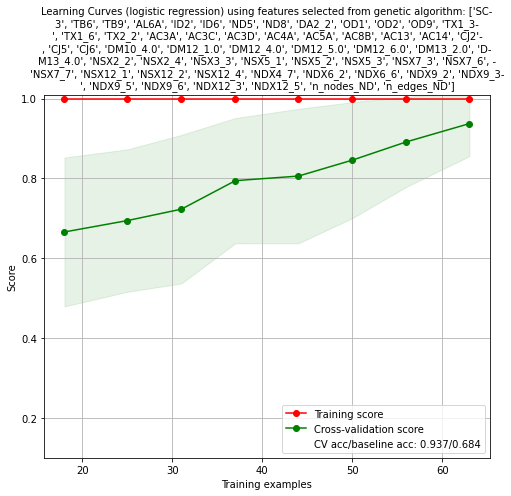

In [117]:
X_new = X[:, model.support_]
selected_features = list(X_df.columns[model.support_])

title = f'Learning Curves ({clf_name}) using features selected from genetic algorithm: {selected_features}'
if len(title) > word_lim:     title = '-\n'.join(title[j:j+word_lim] for j in range(0,len(title), word_lim))  # break line if title too long
scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve_v2(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=5, scoring="accuracy", score=np.mean(scores), baseline=baseline
)

In [67]:
clf_dict = {'logistic regression': LogisticRegression(),
            'decision tree': DecisionTreeClassifier(),
            'SVM': SVC()}

clf_name, clf = 'SVM', SVC()
X_raw = X_np

pipe = Pipeline(steps=[("anova", SelectPercentile(chi2)), (clf_name, clf)]) if clf_name == 'decision tree' \
    else Pipeline(steps=[("anova", SelectPercentile(chi2)), ("scaler", StandardScaler()), (clf_name, clf)])
param_grid = {"anova__percentile": [3, 6, 10, 15, 20, 30, 40]}
cv = ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=5)
search.fit(X_raw, y)

# X = standard_scale(X_raw) if clf_name != 'decision tree' else X_raw
# X_new = X[:,search.best_estimator_['anova'].get_support()]
# selected_features = list(X_df.columns[search.best_estimator_['anova'].get_support()]) # note that the ordering is lexicographical, not magnitude-based
# title = f"Learning Curves ({clf_name}) using features in the {search.best_params_['anova__percentile']}th (chi2) percentile {selected_features}"
# if len(title) > word_lim:     title = '-\n'.join(title[j:j+word_lim] for j in range(0,len(title), word_lim))  # break line if title too long
# plot_learning_curve_v2(
#     clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=5, scoring="accuracy", score=search.best_score_, baseline=baseline
# )

GridSearchCV(cv=ShuffleSplit(n_splits=50, random_state=0, test_size=0.1, train_size=None),
             estimator=Pipeline(steps=[('anova',
                                        SelectPercentile(score_func=<function chi2 at 0x7f631a587dc0>)),
                                       ('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             n_jobs=5,
             param_grid={'anova__percentile': [3, 6, 10, 15, 20, 30, 40]})

In [63]:
search.best_estimator_['anova'].get_support()

array([ True, False, False,  True,  True,  True,  True, False,  True,
       False, False, False, False, False, False,  True, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False,  True, False,
       False,  True,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False,  True, False, False,  True, False, False, False,  True,
       False, False,  True,  True,  True,  True])